# MA333 大数据导论 课程项目报告

## 背景

美国的犯罪率一向居高不下，不同行政区域的行政手段对犯罪率有很明显的影响，不同犯罪类型出现的时间也有较大不同。在本次Project中，我们希望通过一些数据分析方法得到犯罪事件与地区、时间的关系，从而达到了解DC地区不同街区犯罪情况，划分地域危险程度的目的。生命财产安全，是人们选择居住区的一个重要指标，我们也希望通过对犯罪情况和不同类型房产价格的分析得出房屋价格与地区犯罪情况的关系。


## 预处理

读入数据，并根据任务要求取出所需要的数据。

In [4]:
# 读入
import lets_plot
import pandas as pd
import numpy as np


PROPERTIES = pd.read_csv('bigdata/DC_Properties.csv')
PROPERTIES.drop(PROPERTIES[['Unnamed: 0']], axis=1, inplace=True)
print(PROPERTIES.columns)

CRIMES = pd.read_csv('bigdata/DC_Crime.csv')
print(CRIMES.columns)

/home/wycer/miniconda3/envs/bigdata/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM',
       'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'PRICE', 'QUALIFIED',
       'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'GIS_LAST_MOD_DTTM', 'SOURCE', 'CMPLX_NUM', 'LIVING_GBA',
       'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE',
       'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT',
       'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT'],
      dtype='object')
Index(['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',


## 数据可视化以及寻找数据关系


In [5]:
# 删去重复的数据
crimes = CRIMES.drop_duplicates(inplace=False)

from lets_plot import *

LetsPlot.setup_html()

p = ggplot(crimes, aes(x='YEAR')) + ggsize(500, 250)
p + geom_histogram(binwidth=.5)
p + geom_histogram(
    aes(y='..density..'), binwidth=.5, colour="black", fill="white")


## 数据相关性分析

### 不同类型犯罪的出现与时间、犯罪方式的相关性

In [9]:
# 犯罪类型/方法/时间
from lets_plot import *
from lets_plot.bistro.corr import *

LetsPlot.setup_html()

df = crimes[["offensegroup", "SHIFT", "offensekey", "METHOD"]]

mpg_df = pd.get_dummies(df, columns=["offensegroup", "SHIFT", "offensekey", "METHOD"])
corr_plot(mpg_df).tiles().labels().build() + ggtitle("Tiles and labels")

从图中可以发现：

1. 谋杀类型的犯罪与午夜时间有弱正相关，与其余时间均为负相关。
2. 抢劫类型的犯罪与午夜有正相关，与白天有负相关。
3. 性犯罪则与时间并无明显的相关关系。
4. 犯罪物品中与枪支和刀相关的犯罪，与暴力犯罪（抢劫、谋杀）有强正相关关系。
5. 犯罪物品中与枪支相关的犯罪，与犯罪类型是抢劫或谋杀呈强正相关关系。

### 犯罪事件与地理位置的相关性

<ipython-input-11-c95ceaf7a465>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['count_by_cluster'] = 1
<ipython-input-11-c95ceaf7a465>:38: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  merged.apply(lambda x: ax.annotate(s=x['count_by_cluster'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


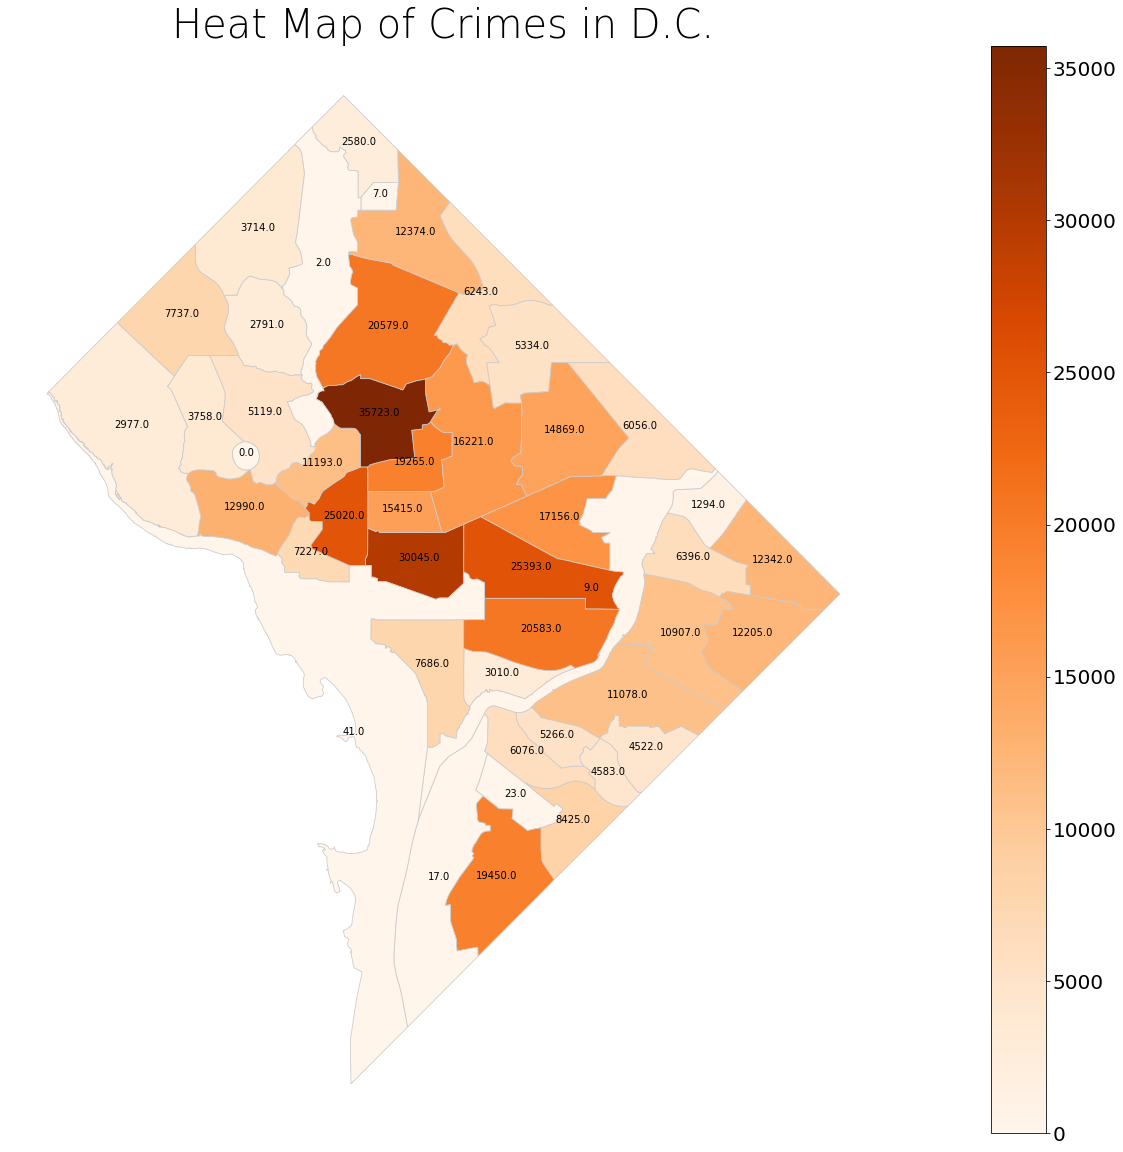

In [11]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd

dc_map = gpd.read_file('bigdata/Neighborhood_Clusters.shp')
dc_map['neighbourhood'] = dc_map['NAME'].str.lower()

# dc_map.sample(5)

data = crimes[crimes['NEIGHBORHOOD_CLUSTER'].notna()]
data['count_by_cluster'] = 1
dataByNeighbourhood = data.groupby('NEIGHBORHOOD_CLUSTER').count()[['count_by_cluster']].reset_index()
dataByNeighbourhood['NEIGHBORHOOD_CLUSTER'] = dataByNeighbourhood['NEIGHBORHOOD_CLUSTER'].str.lower()
dataByNeighbourhood.sort_values('count_by_cluster', ascending=False).head(10)


merged = dc_map.set_index('neighbourhood').join(dataByNeighbourhood.set_index('NEIGHBORHOOD_CLUSTER'))
merged = merged.reset_index()
merged = merged.fillna(0)
# print("Merged: ===============\n", merged)
# merged[['neighbourhood', 'FIELD_11', 'FIELD_12', 'geometry', 'count']].sample(5)

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Crimes in D.C.', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = 0, max(merged['count_by_cluster'])
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

ax = merged.plot('count_by_cluster', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

merged.apply(lambda x: ax.annotate(s=x['count_by_cluster'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1)
plt.show()

/home/wycer/miniconda3/envs/bigdata/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
<ipython-input-113-dae07c940930>:135: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  merged.apply(lambda x: ax.annotate(s=x['type'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


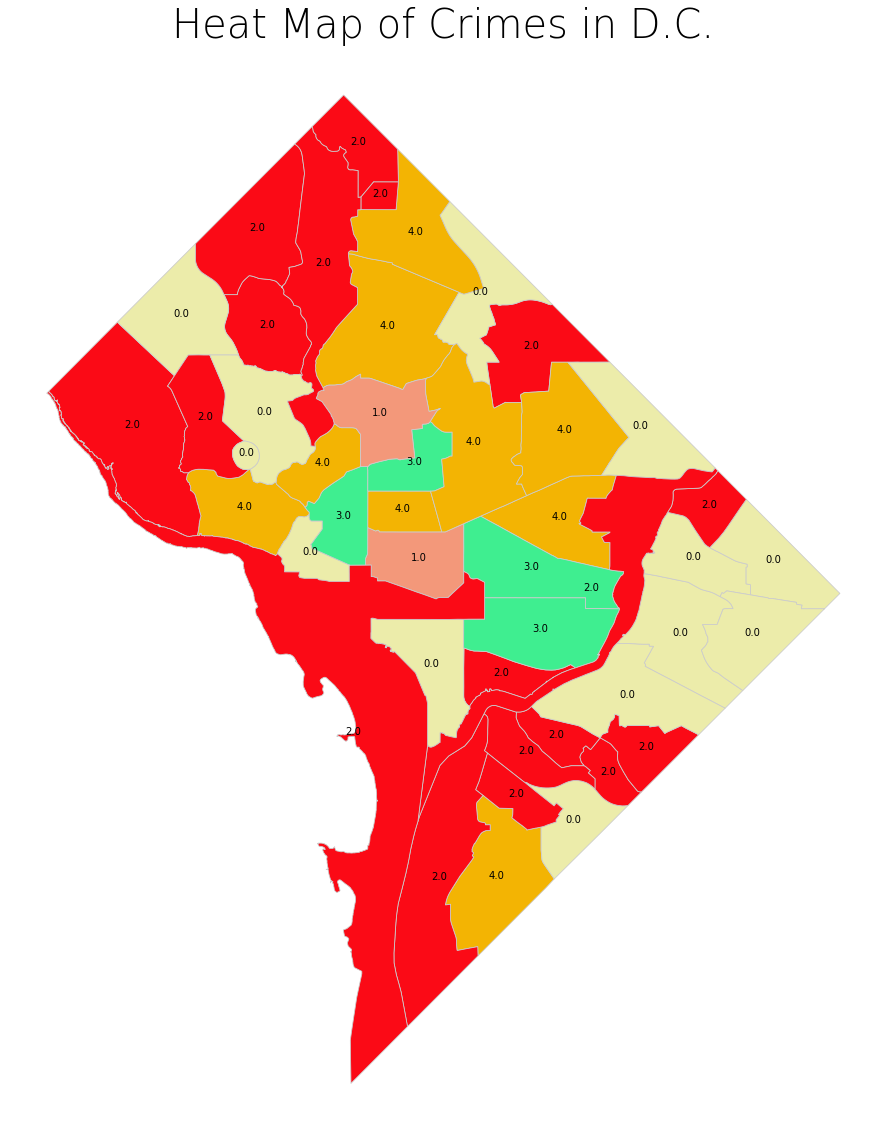

In [113]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap
# 做一个地域的分类（使用地域的犯罪情况）
# Test GEO
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd

dc_map = gpd.read_file('bigdata/Neighborhood_Clusters.shp')
dc_map['neighbourhood'] = dc_map['NAME'].str.lower()

# dc_map.sample(5)

data = crimes[crimes['NEIGHBORHOOD_CLUSTER'].notna()]
data = data[['NEIGHBORHOOD_CLUSTER', 'offensekey']]
data = pd.get_dummies(data, columns=["offensekey"])

data = data.groupby('NEIGHBORHOOD_CLUSTER').sum().reset_index()
data_set = data.drop(columns=['NEIGHBORHOOD_CLUSTER'], inplace=False)
data_set.head(10)

# dataByNeighbourhood = data.groupby('NEIGHBORHOOD_CLUSTER').count()[['count_by_cluster']].reset_index()
# dataByNeighbourhood['NEIGHBORHOOD_CLUSTER'] = dataByNeighbourhood['NEIGHBORHOOD_CLUSTER'].str.lower()
# data_set.sort_values('NEIGHBORHOOD_CLUSTER', ascending=False).head(100)

# data_set = data[['NEIGHBORHOOD_CLUSTER']]
# snapshot(data_set)
# # print()

import pandas as pd
from sklearn import cluster
model = cluster.KMeans(n_clusters=5, max_iter=100, n_jobs=4, init="k-means++")
model.fit(data_set)

r = pd.concat([data, pd.Series(model.labels_, index=data.index)], axis=1)
r.columns = list(data.columns) + ['type']

r.head(10)

# ['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',
#        'END_DATE', 'offense-text', 'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD',
#        'YEAR', 'offensekey', 'BID', 'sector', 'PSA', 'ucr-rank', 'BLOCK_GROUP',
#        'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'START_DATE', 'CCN', 'OFFENSE',
#        'OCTO_RECORD_ID', 'ANC', 'REPORT_DAT', 'METHOD', 'location', 'LATITUDE',
#        'count_by_cluster'],

merged = dc_map.set_index('neighbourhood').join(r.set_index('NEIGHBORHOOD_CLUSTER'))
merged = merged.reset_index()
merged = merged.fillna(0)
# print("Merged: ===============\n", merged)
# merged[['neighbourhood', 'FIELD_11', 'FIELD_12', 'geometry', 'count']].sample(5)

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Crimes in D.C.', fontdict={'fontsize': '40', 'fontweight' : '3'})

vmin, vmax = 0, max(merged['type'])
# cmap = matplotlib.colors.ListedColormap ( numpy.random.rand ( 256,3))
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
sm = rand_cmap(100, type='bright', first_color_black=False, last_color_black=False, verbose=False)
# cbar = fig.colorbar(sm)
# cbar.ax.tick_params(labelsize=20)

ax = merged.plot('type', cmap=sm, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

merged.apply(lambda x: ax.annotate(s=x['type'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1)
plt.show()

In [17]:
def snapshot(df):
    # 查看所有行
    print(df)

    # 查看前 5 行
    print(df.head())
    print(df.head(5))

    # 查看后 5 行
    print(df.tail())
    print(df.tail(5))

    # 查看行标签(index)，列标签(columns)和数据
    print(df.index)
    print(df.index.names)
    print(df.columns)
    print(df.values)

    # 查看基本统计信息
    print(df.info())
    print(df.describe())

In [ ]:
def group(plots):
    bunch = GGBunch()
    for idx, p in enumerate(plots):
        x = (idx % 2) * 450
        y = int(idx / 2) * 350
        bunch.add_plot(p, x, y)

    return bunch

corr_plot(mpg_df).tiles().labels().build() + ggtitle("Tiles and labels")


In [ ]:
# Test GEO
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd

dc_map = gpd.read_file('bigdata/Neighborhood_Clusters.shp')
# dc_map.plot()
print(dc_map)

crs={'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(crimes["LONGITUDE"], crimes["LATITUDE"])]
geodata=gpd.GeoDataFrame(crimes,crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(7,7))

dc_map.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")
#You can use different 'cmaps' such as jet, plasm,magma, infereno,cividis, binary...(I simply chose cividis)
geodata.plot(ax=ax, color='red', markersize=5)
fig.suptitle('Crimes', fontsize=12)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')